## Transfer Learning Part 2 : Fine Tuning


In [ ]:
# check if GPU used
!nvidia-smi


Wed Jul  7 09:55:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Helper Functions
Create common functions into helper.py and import it into the notebook

In [ ]:
# download helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-07 09:57:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-07 09:57:11 (77.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Get some data
Use pre-trained models within 'tf.keras.applications' and apply them on our problem


In [ ]:
# download the file
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-07-07 09:57:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.80, 142.250.188.208, 142.251.33.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   165MB/s    in 1.0s    

2021-07-07 09:57:22 (165 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# call unzip function
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
# check directories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:
# create directories
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [ ]:
import tensorflow as tf

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5


In [ ]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMAGE_SHAPE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMAGE_SHAPE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
train_data_10_percent.take

<bound method DatasetV2.take of <BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>>

## Model 0 : Build Transfer Learning model using Keras Function
Whiel Sequential API is straight forward and run our layers in sequential order, Functional API gives more flexibility to models


In [ ]:
# Create base model using tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Free base model (so that underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# create inputs to model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# If using Resnet50v2 then need to normalize inputs, not needed for Efficientnet
#X = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# pass inputs to base model
X = base_model(inputs)
print(f"Shape after passing inputs through base model : {X.shape}")

# average pool the output models
X = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(X)
print(f"Shape after global average pooling 2D : {X.shape}")

# create output activation layer 
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(X)

# combine input and outputs into model
model_0 = tf.keras.Model(inputs, outputs)


16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model : (None, 7, 7, 1280)
Shape after global average pooling 2D : (None, 1280)


In [ ]:
# compile model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
# fit model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=EPOCHS,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25 * len(test_data_10_percent)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])


Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210707-095848
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 46s 441ms/step - loss: 1.9865 - accuracy: 0.3613 - val_loss: 1.4142 - val_accuracy: 0.6875
Epoch 2/5
24/24 [==============================] - 5s 213ms/step - loss: 1.1889 - accuracy: 0.7320 - val_loss: 0.9507 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - 5s 208ms/step - loss: 0.8673 - accuracy: 0.7973 - val_loss: 0.7579 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============================] - 5s 209ms/step - loss: 0.7043 - accuracy: 0.8253 - val_loss: 0.6679 - val_accuracy: 0.8174
Epoch 5/5
24/24 [==============================] - 5s 211ms/step - loss: 0.6038 - accuracy: 0.8520 - val_loss: 0.6049 - val_accuracy: 0.8355


In [ ]:
# model summary
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Evaludate Model
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 10s 116ms/step - loss: 0.6197 - accuracy: 0.8412


[0.6196798086166382, 0.8411999940872192]

In [ ]:
# check layers in base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)
  

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# base model summary
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

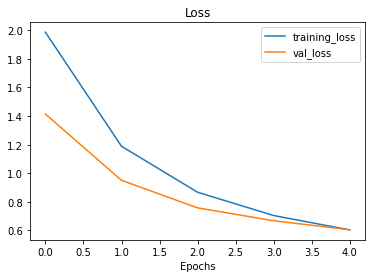

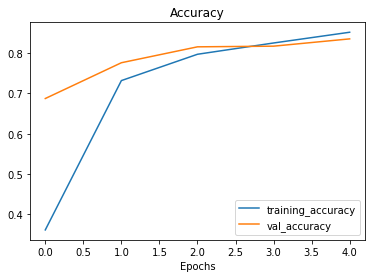

In [ ]:
# plot loss curves
plot_loss_curves(history_0)

In [ ]:
# Define input shape
input_shape =  (1, 2, 3, 4)

# create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random Input Tensor :\n {input_tensor}\n")

# pass random tensor through Global Average Pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D Global Average Pooled random tensor : \n {global_average_pooled_tensor}\n")

# check shape above tensors
print(f"Shape of input tensor : {input_tensor.shape}")
print(f"Shape of global average pooled 2D tensor : {global_average_pooled_tensor.shape}")


Random Input Tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337  -1.4075519 ]
   [-2.3880599  -1.0392479  -0.5573232   0.539707  ]
   [ 1.6994323   0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144  0.8504023 ]
   [-0.40604794 -3.0258412   0.9058464   0.29855987]
   [-0.22561555 -0.7616443  -1.8917141  -0.93847126]]]]

2D Global Average Pooled random tensor : 
 [[-0.26500773 -1.216256   -0.5584684  -0.15365022]]

Shape of input tensor : (1, 2, 3, 4)
Shape of global average pooled 2D tensor : (1, 4)


## Run Series of Tranfer Learning Experiments

1. Model_1 : use feature extractor transfer learning with 1% of training data with data augmentation
2. Model_2 : use feature extractor transfer learning with 10% of training data with data augmentation
3. Model_3 : use fine-tuning transfer learning with 10% of training data with data augmentation
4. Model_4 : use fine-tuning transfer learning with 100% of training data with data augmentation


Note : throughout all experiments same test dataset will be used to evaluate to ensure consistency


In [ ]:
# download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2021-07-07 10:02:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 172.217.15.112, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   238MB/s    in 0.5s    

2021-07-07 10:02:56 (238 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# create dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"


In [ ]:
# dir walk thru
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'

In [ ]:
# setup data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMAGE_SHAPE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SHAPE,
                                                                batch_size=BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotation, zoom etc
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      # preprocessing.Rescale(1./255)   # needed only for Resnet50v2
], name="data_augmentation")


## Visualize data augmentation layer


(-0.5, 357.5, 438.5, -0.5)

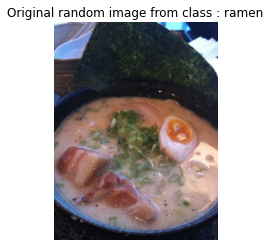

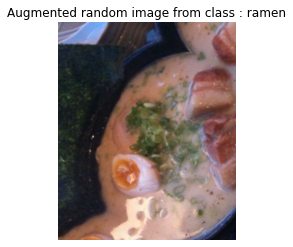

In [ ]:
# view a random image and compare with augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# read random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class : {target_class}")
plt.axis(False)

# plot augmented image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img/255.))
plt.title(f"Augmented random image from class : {target_class}")
plt.axis(False)

## Model 1 : Feature Extraction transfer learning on 1% of data augmentation


In [ ]:
# setup input shape and base model, freeze base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# add data augmentation Sequential model layer
x = data_augmentation(inputs)

# give base_model inputs
x = base_model(x, training=False)

# pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# put dense layer as output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# make model using input and outputs
model_1 = keras.Model(inputs, outputs)

# compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=EPOCHS,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210707-100329


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
3/3 [==============================] - 12s 3s/step - loss: 2.4648 - accuracy: 0.0714 - val_loss: 2.2417 - val_accuracy: 0.1595
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1984 - accuracy: 0.1000 - val_loss: 2.1205 - val_accuracy: 0.2451
Epoch 3/5
3/3 [==============================] - 3s 2s/step - loss: 1.9704 - accuracy: 0.3143 - val_loss: 2.0139 - val_accuracy: 0.3388
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8148 - accuracy: 0.5143 - val_loss: 1.9201 - val_accuracy: 0.3931
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6871 - accuracy: 0.6429 - val_loss: 1.8267 - val_accuracy: 0.4408


In [ ]:
# get summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# evaluate on full test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 9s 112ms/step - loss: 1.8275 - accuracy: 0.4408


[1.8274999856948853, 0.4408000111579895]

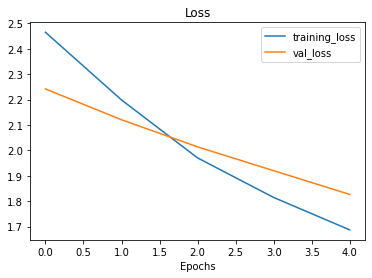

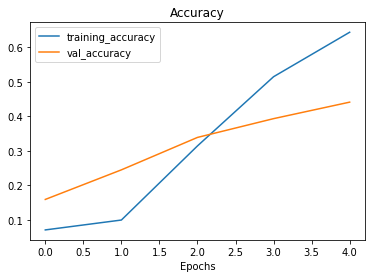

In [ ]:
# plot loss curves
plot_loss_curves(history_1)

## Model 2 : Feature extraction transfer learning model with 10% of data and data augmentation

In [ ]:
# we already had 10 percent data downloaded, if not download unzip it

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# set data input
IMAGE_SHAPE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMAGE_SHAPE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SHAPE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Walk thru dir
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:
# create model 2 with data augmentation

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# build augmentation layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2)
                                # preprocessing.Rescaling(1./255) # needed for Resnet50v2
])



In [ ]:
# create base model
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create inputs and outputs
inputs = layers.Input(shape=input_shape, name="input_layer")
X = data_augmentation(inputs)
X = base_model(X, training=False)
X = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(X)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(X)

model_2 = tf.keras.Model(inputs, outputs)

# compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
# get summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


# create model check point

Model checkpoint callback immediately saves our model (full model or just the weights) during training.


In [ ]:
# set checkpoint path
checkpoint_path = "10_percent_model_checkpoint_weights/checkpoint.ckpt"

# create ModelCheckpoint callback that saves model weight's only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         sae_best_only=False,
                                                         sae_freq="epoch",
                                                         verbose=1)


In [ ]:
# fit model saving checkpoints every epoch
history_2 = model_2.fit(train_data_10_percent,
                        epochs=EPOCHS,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_data_aug"),
                                   checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210707-105507
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 23s 731ms/step - loss: 2.0150 - accuracy: 0.3160 - val_loss: 1.4963 - val_accuracy: 0.6469

Epoch 00001: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 14s 585ms/step - loss: 1.3482 - accuracy: 0.6533 - val_loss: 1.0323 - val_accuracy: 0.7844

Epoch 00002: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 13s 506ms/step - loss: 1.0534 - accuracy: 0.7360 - val_loss: 0.8369 - val_accuracy: 0.8094

Epoch 00003: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 10s 405ms/step - loss: 0.9005 - accuracy: 0.7693 - val_loss: 0.7329 - val_accuracy: 0.8234

Epoch 00004: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 12s 501ms/step - loss: 0.8023 - accuracy: 0.7827 - val_loss: 0.

In [ ]:
# get summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# evaluate model
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 9s 111ms/step - loss: 0.6940 - accuracy: 0.8196


[0.6940246224403381, 0.819599986076355]

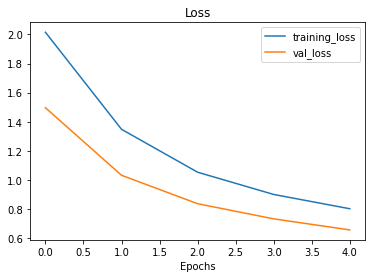

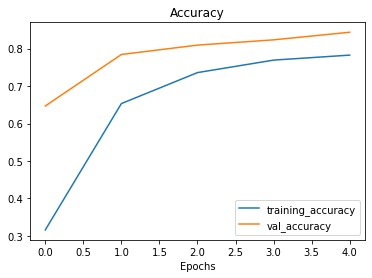

In [ ]:
# plot loss curve
plot_loss_curves(history_2)

## Loading in checkpointed weights
Loading in checkpointed weights returns model to a specific checkpoint


In [ ]:
# Load saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# evaluate model with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 111ms/step - loss: 0.6940 - accuracy: 0.8196


In [ ]:
# check if loaded model results are close to previous model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))


array([ True,  True])

In [ ]:
# check differences between two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


## Model 3 : Fine tuning an existing model on 10% data

Note : 
Fine tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data


In [ ]:
# check layers in loaded model
model_2.layers


In [ ]:
# Are these trainable
for layer in model_2.layers:
  print(layer, layer.trainable)
  

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f04f27753d0> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f04f2746a10> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f03f690fa90> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f04f2775c50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f03f691cc10> True


In [ ]:
# what layers in our base model and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# checka if any trainable variables in base model
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# to begin fine tuning, lets start by setting last 10 layers of base model.trainable as True
base_model.trainable = True

# Free all layers except for last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (needs recompile of model every time we make changes)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])



## Note : 
When using fine tuning, best practice to lower learning rate by 10X

In [ ]:
# check whihc layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# re-check on trainable variables
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = EPOCHS + 5

# refit model
history_2_fine = model_2.fit(train_data_10_percent,
                             epochs=fine_tune_epochs,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data,
                             validation_steps=int(0.25 * len(test_data)),
                             initial_epoch=history_2.epoch[-1],
                             callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                    experiment_name="10_percent_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210707-134825
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 23s 647ms/step - loss: 0.6920 - accuracy: 0.8040 - val_loss: 0.5382 - val_accuracy: 0.8339
Epoch 6/10
24/24 [==============================] - 10s 414ms/step - loss: 0.5786 - accuracy: 0.8213 - val_loss: 0.4712 - val_accuracy: 0.8487
Epoch 7/10
24/24 [==============================] - 10s 390ms/step - loss: 0.5096 - accuracy: 0.8600 - val_loss: 0.4835 - val_accuracy: 0.8421
Epoch 8/10
24/24 [==============================] - 9s 370ms/step - loss: 0.4554 - accuracy: 0.8680 - val_loss: 0.4745 - val_accuracy: 0.8388
Epoch 9/10
24/24 [==============================] - 9s 359ms/step - loss: 0.4158 - accuracy: 0.8613 - val_loss: 0.4468 - val_accuracy: 0.8553
Epoch 10/10
24/24 [==============================] - 8s 344ms/step - loss: 0.3603 - accuracy: 0.9000 - val_loss: 0.4749 - val_accuracy: 0.8454


In [ ]:
# Evaluate fine tuned model
results_fine_tune_10_percent = model_2.evaluate(test_data)
results_fine_tune_10_percent

79/79 [==============================] - 9s 113ms/step - loss: 0.4797 - accuracy: 0.8392


[0.4797496497631073, 0.8392000198364258]

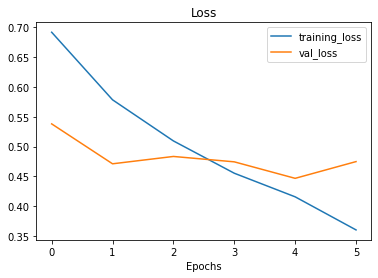

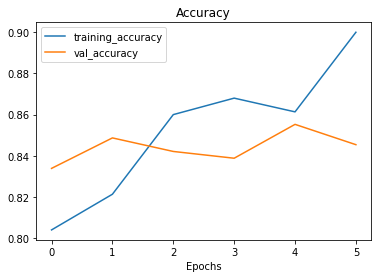

In [ ]:
# loss curve
plot_loss_curves(history_2_fine)

In [ ]:
# create function to compare histories

def compare_history(original_history, new_history, initial_epochs=5):
  """
  compares two tensorflow history objects
  """

  # get original hisotry measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Val Accuracy")

  # make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Val Loss")



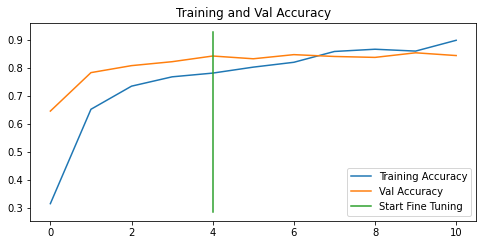

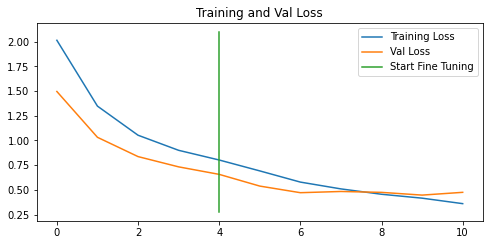

In [ ]:
compare_history(history_2, history_2_fine, initial_epochs=5)

# Model 4 : Fine tune existing model on all data (100%)

In [ ]:
# download complete data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2021-07-07 14:33:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 142.250.73.208, 142.250.65.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   199MB/s    in 2.5s    

2021-07-07 14:33:47 (199 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# set up dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir_all_data = "10_food_classes_all_data/test"


In [ ]:
# how many images
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 

In [ ]:
# setup inputs
import tensorflow as tf
IMAGE_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(test_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMAGE_SIZE)

test_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(test_dir_all_data,
                                                                                label_mode="categorical",
                                                                                image_size=IMAGE_SIZE)


Found 2500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Evaluate model 2 on full test data
model_2.evaluate(test_data_10_classes_full)

79/79 [==============================] - 10s 117ms/step - loss: 0.4797 - accuracy: 0.8392


[0.4797496199607849, 0.8392000198364258]

In [ ]:
results_10_percent_data_aug

[0.6940246224403381, 0.819599986076355]

In [ ]:
# Load weights from checkpoint
model_2.load_weights(checkpoint_path)


In [ ]:
# evaluate model_2 with checkpoint weights
model_2.evaluate(test_data_10_classes_full)

79/79 [==============================] - 10s 118ms/step - loss: 0.6940 - accuracy: 0.8196


[0.6940245628356934, 0.819599986076355]

In [ ]:
# check if model_2 is reverted back
results_10_percent_data_aug

[0.6940246224403381, 0.819599986076355]

In [ ]:
# check which layers are tunable
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 sequential True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# let's drill into base model to check which is trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# re-compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])



In [ ]:
# fit model
fine_tune_epochs = EPOCHS + 5

history_2_fine_full_data = model_2.fit(train_data_10_classes_full,
                                       epochs=fine_tune_epochs,
                                       steps_per_epoch = len(train_data_10_classes_full),
                                       validation_data = test_data_10_classes_full,
                                       validation_steps = int(0.25 * len(test_data_10_classes_full)),
                                       initial_epoch=history_2.epoch[-1],
                                       callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                              experiment_name="full_10_classes_fine_tune")])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune/20210707-154842
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


79/79 [==============================] - 25s 237ms/step - loss: 0.6724 - accuracy: 0.7868 - val_loss: 0.4043 - val_accuracy: 0.8618
Epoch 6/10
79/79 [==============================] - 16s 193ms/step - loss: 0.5342 - accuracy: 0.8248 - val_loss: 0.3874 - val_accuracy: 0.8750
Epoch 7/10
79/79 [==============================] - 25s 312ms/step - loss: 0.4593 - accuracy: 0.8476 - val_loss: 0.2866 - val_accuracy: 0.9079
Epoch 8/10
79/79 [==============================] - 22s 270ms/step - loss: 0.4356 - accuracy: 0.8560 - val_loss: 0.2772 - val_accuracy: 0.9178
Epoch 9/10
79/79 [==============================] - 23s 282ms/step - loss: 0.3755 - accuracy: 0.8764 - val_loss: 0.2399 - val_accuracy: 0.9211
Epoch 10/10
79/79 [==============================] - 22s 270ms/step - loss: 0.3523 - accuracy: 0.8784 - val_loss: 0.2192 - val_accuracy: 0.9342


In [ ]:
# evaluate model
results_fine_tune_full_data = model_2.evaluate(test_data_10_classes_full)
results_fine_tune_full_data


79/79 [==============================] - 10s 117ms/step - loss: 0.2345 - accuracy: 0.9264


[0.2344731241464615, 0.9264000058174133]

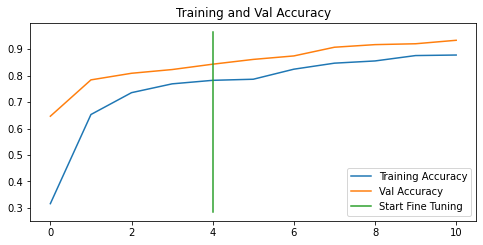

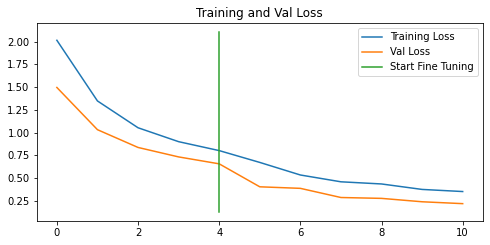

In [ ]:
# how did fine tuning go with more data
compare_history(original_history=history_2,
                new_history=history_2_fine_full_data,
                initial_epochs=5)


## Viewing experiment data on Tensorboard

In [ ]:
# view tensorboard logs
# upload tensorboard dev records

!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning Experiments with 10 Food Classes" \
--description "Series of different transfer learning experiments with varying amount" \
--one_shot


2021-07-07 16:02:47.070635: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3

# experiments published in link
https://tensorboard.dev/experiment/9XM7GKKLQXeAwQ7ALM7h0A/
